# Performing brain-behaviour canonical correlation analysis using Nilearn and Sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
plt.style.use('ggplot')
data_dir = 'data/'

## Organise the data

We can download imaging and phenotypic data from the ABIDE (https://fcon_1000.projects.nitrc.org/indi/abide/) dataset using nilearn.

In [2]:
from nilearn import datasets
#datasets.fetch_abide_pcp(data_dir=data_dir,band_pass_filtering=True, derivatives=['rois_cc200'])

Load the behavioural and imaging data

In [3]:
phenotype_df = pd.read_csv(data_dir+'ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv')

# filter the df and drop any rows with NaNs
measures = ['SUB_ID','FILE_ID','DSM_IV_TR','VIQ','PIQ','ADI_R_SOCIAL_TOTAL_A','ADI_R_VERBAL_TOTAL_BV','ADI_RRB_TOTAL_C','ADI_R_ONSET_TOTAL_D']
phenotype_df = phenotype_df.loc[:,measures]
phenotype_df[phenotype_df== -9999.0]=np.nan
phenotype_df = phenotype_df.dropna()
phenotype_df = phenotype_df.reset_index(drop=True)

phenotype_df.DSM_IV_TR[phenotype_df.DSM_IV_TR==0.0]='Control'
phenotype_df.DSM_IV_TR[phenotype_df.DSM_IV_TR==1.0]='Autism'
phenotype_df.DSM_IV_TR[phenotype_df.DSM_IV_TR==2.0]='Aspergers'
phenotype_df.DSM_IV_TR[phenotype_df.DSM_IV_TR==3.0]='PPD-NOS'
phenotype_df.DSM_IV_TR[phenotype_df.DSM_IV_TR==4.0]='Asp. or PPD-NOS'
display(phenotype_df)

,SUB_ID,FILE_ID,DSM_IV_TR,VIQ,PIQ,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D
0,50003,Pitt_0050003,Autism,128.0,115.0,27.0,22.0,5.0,3.0
1,50004,Pitt_0050004,Autism,108.0,117.0,19.0,12.0,5.0,3.0
2,50005,Pitt_0050005,Autism,117.0,118.0,23.0,19.0,3.0,4.0
3,50006,Pitt_0050006,Autism,99.0,119.0,13.0,10.0,4.0,3.0
4,50007,Pitt_0050007,Autism,106.0,112.0,21.0,14.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...
234,51574,SBL_0051574,Aspergers,105.0,121.0,21.0,20.0,4.0,3.0
235,51575,SBL_0051575,Aspergers,100.0,113.0,15.0,11.0,1.0,3.0
236,51580,SBL_0051580,PPD-NOS,117.0,121.0,18.0,8.0,3.0,1.0
237,51582,SBL_0051582,Aspergers,116.0,121.0,18.0,9.0,5.0,3.0


In [4]:
# imaging data
fc = []
missing_index = []
for i,file_id in enumerate(phenotype_df.FILE_ID):
    try:
        file = data_dir+'ABIDE_pcp/cpac/filt_noglobal/'+file_id+'_rois_cc200.1D'
        data = np.loadtxt(file)
        
        # use correlation as an FC measure
        corr_mat = np.corrcoef(data.T)
        corr_vec = corr_mat[np.triu_indices(len(corr_mat),k=1)]
        corr_vec[np.isnan(corr_vec)]=0
        fc.append(corr_vec)
    except:
        phenotype_df.drop(i,inplace=True)
        
fc = np.array(fc)
phenotype_df = phenotype_df.reset_index(drop=True)
display(phenotype_df)

,SUB_ID,FILE_ID,DSM_IV_TR,VIQ,PIQ,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D
0,50003,Pitt_0050003,Autism,128.0,115.0,27.0,22.0,5.0,3.0
1,50004,Pitt_0050004,Autism,108.0,117.0,19.0,12.0,5.0,3.0
2,50005,Pitt_0050005,Autism,117.0,118.0,23.0,19.0,3.0,4.0
3,50006,Pitt_0050006,Autism,99.0,119.0,13.0,10.0,4.0,3.0
4,50007,Pitt_0050007,Autism,106.0,112.0,21.0,14.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...
178,51461,Caltech_0051461,Asp. or PPD-NOS,111.0,84.0,25.0,15.0,5.0,3.0
179,51463,Caltech_0051463,Autism,101.0,103.0,24.0,18.0,4.0,3.0
180,51464,Caltech_0051464,Autism,118.0,109.0,22.0,17.0,5.0,5.0
181,51572,SBL_0051572,Aspergers,93.0,110.0,4.0,2.0,2.0,0.0


# Do a canonical correlation analysis using sklearn

In [5]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

# reduce the dimensionality of the connectivity values
pca = PCA(n_components=20).fit(fc)
X = pca.transform(fc)

# select the behavioural variables
y = np.vstack((phenotype_df.VIQ.values,
               phenotype_df.PIQ.values,
              phenotype_df.ADI_R_SOCIAL_TOTAL_A.values,
              phenotype_df.ADI_R_VERBAL_TOTAL_BV.values,
              phenotype_df.ADI_RRB_TOTAL_C.values,
              phenotype_df.ADI_R_ONSET_TOTAL_D.values)).T

# do the CCA
n_components = y.shape[1]
cca = CCA(n_components=n_components).fit(X,y)

## Transpose the results into useful spaces

In [6]:
# save the canonical correlation (corr: x,y)
cca.mode_r = []
for component in range(n_components):
    cca.mode_r.append(np.corrcoef(cca.x_scores_[:,component],cca.y_scores_[:,component])[0,1])
    
# correlate behavioural patterns with canonical variate scores (y)
cca.y_score_correlation = np.zeros((np.shape(y)[1],n_components))
for component in range(n_components):
    for beh in range(np.shape(y)[1]):
        cca.y_score_correlation[beh,component] = np.corrcoef(y[:,beh].T,cca.y_scores_[:,component])[0,1]

# correlate fc edges with canonical variate scores (x)
cca.x_score_correlation = np.zeros((np.shape(fc)[1],n_components))
for component in range(n_components):
    cca.x_score_correlation[:,component] = np.corrcoef(cca.x_scores_[:,0],fc.T)[1::,0]
    
# put CCA weights back in node by node space for visualization
n_nodes = 200
cca.x_weights_mat = np.zeros((n_nodes,n_nodes,n_components))
for i in range(n_components):
    data = cca.x_score_correlation[:,i]
    data_mat = np.zeros((n_nodes,n_nodes))
    data_mat[np.triu_indices(n_nodes,k=1)] = data
    cca.x_weights_mat[:,:,i] = data_mat

# add individual weightings to dataframe
for component in range(n_components):
    phenotype_df['x_score_'+str(component)] = cca.x_scores_[:,component]
    phenotype_df['y_score_'+str(component)] = cca.y_scores_[:,component]

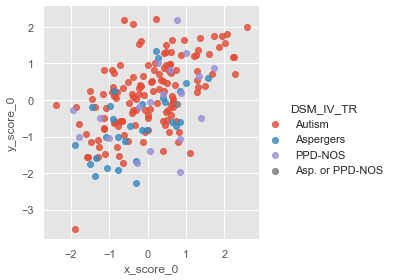

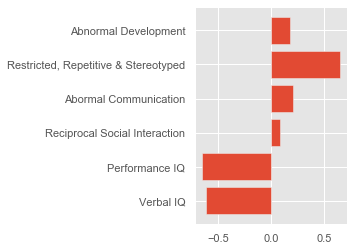

In [7]:
sns.lmplot(x='x_score_0',y='y_score_0',hue='DSM_IV_TR',fit_reg=False,height=4,data=phenotype_df)
plt.show()

plt.subplot(1,2,2)
x = cca.y_score_correlation[:,0]
labels = ['Verbal IQ','Performance IQ','Reciprocal Social Interaction','Abormal Communication','Restricted, Repetitive & Stereotyped','Abnormal Development']
plt.barh(np.arange(len(x)), x, align='center')
plt.yticks(range(len(labels)), labels)
plt.show()

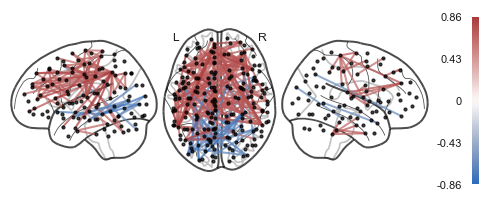

In [8]:
from nilearn import plotting
# grab center coordinates for atlas labels
#from https://github.com/preprocessed-connectomes-project/abide/blob/master/preprocessing/resources/abide_rois/CC200.nii.gz
coordinates = plotting.find_parcellation_cut_coords(labels_img='data/CC200.nii.gz')

cm = cca.x_weights_mat[:,:,0].copy()
cm = cm + cm.T
cm[abs(cm)<0.3] = 0 # perform some thresholding
cm_degree_plot = ((np.argsort(np.sum(abs(cm), axis=1)))/len(cm))*10
plotting.plot_connectome(cm + cm.T,
                         coordinates,
                         node_color='black',
                         node_size=10,
                         edge_cmap='vlag',
                         edge_threshold = "0.1%",
                         display_mode='lzr',
                         edge_kwargs={'Alpha':0.75,'lw':2},
                         node_kwargs={'Alpha':0.75,'lw':1},
                         colorbar=True)
plotting.show()